## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [2]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    
    for n in range(nt + 1):
      for j in range(row): 
        for i in range(col):
          un[j][i] = u[j][i] 
      
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2]) + nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
          
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
    return 0 

## Numba accelerator

In [3]:
@njit(fastmath=True)
def solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    
    for n in range(nt + 1):
      for j in range(row): 
        for i in range(col):
          un[j][i] = u[j][i] 
      
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2]) + nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
          
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
    return 0 

## Pyccel accelerator

In [4]:
def solve_2d_diff_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', nu:'float'):
    row, col = u.shape
    
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    
    for n in range(nt + 1):
      for j in range(row): 
        for i in range(col):
          un[j][i] = u[j][i] 
      
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[j-1, i-1] + nu * dt / dx**2 * (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1,i-2]) + nu * dt / dy**2 * (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2,i-1])) 
          
          u[0, :] = 1
          u[-1, :] = 1
          u[:, 0] = 1
          u[:, -1] = 1 
    return 0 

## Inputs

/tmp/ipykernel_12784/1997063914.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


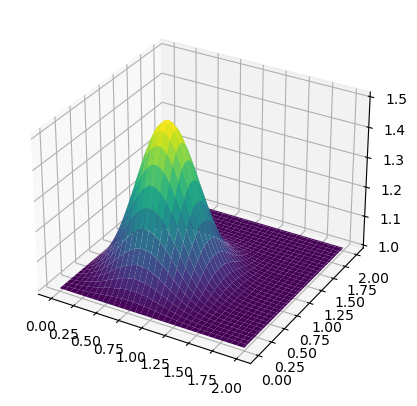

In [5]:
###variable declarations
nt = 501
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .15
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

la forme qui ressemble a la clauche gaussienne n'est pas la vraie forme que nous devons trouver, ceci est du a l'amplification des erreus de descritisation et d'approximation de notre equation par methode de diff finie des methodes numerique.

## Call Funtions

### Pure function

In [6]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

53.8 s ± 625 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [8]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

2.3 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [9]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [10]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

868 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Nous constatons pour cette fonction l'enorme difference de performance entre le calcul par defaut de python et numba et aussi pyccel accelerator qui les depassent de loin.